In [1]:
import pymysql.cursors
import pandas as pd
from sklearn import preprocessing
import numpy as np
import re
import datetime

# 训练

## 获取全量的竞彩比赛列表

In [2]:
connection = pymysql.connect(host='localhost', user='root', password='breadt@2019', db='breadt-football-ml', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = 'select * from `breadt_football_game_list`;'
    cursor.execute(sql)
    rows = cursor.fetchall()
    
    train_game_list_df = pd.DataFrame(rows)
    
    connection.close()

train_game_list_df['source'] = 'jc'

## 获取全量的胜负彩比赛列表

In [3]:
connection = pymysql.connect(host='localhost', user='root', password='breadt@2019', db='breadt-football-ml', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = 'select * from `breadt_lottery_info`;'
    cursor.execute(sql)
    rows = cursor.fetchall()
    
    train_lottery_game_list_df = pd.DataFrame(rows)
    
    connection.close()

train_lottery_game_list_df['source'] = 'lottery'

## 合并竞彩比赛列表和胜负彩比赛列表

In [4]:
tmp = train_lottery_game_list_df.drop(['issue'], axis=1)
df = pd.concat([train_game_list_df, tmp])
df = df[['matchid', 'game', 'home_team', 'visit_team', 'gs', 'gd', 'gn', 'time', 'result', 'win_bet_return', 'draw_bet_return', 'lose_bet_return', 'source']]
df = df.drop_duplicates(subset=['matchid'])

## **设定训练范围** 并处理数据

In [5]:
# match_group = ['澳超', '英超', '德甲', '德乙', '法甲', '西甲', '意甲', '日职', '英甲', '英冠', '苏超', '法乙', '葡超', '荷甲', '荷乙', '韩K联', '瑞典超', '挪超', '美职', '日乙', '俄超', '比甲', '瑞典甲', '法丙', '挪甲', '英乙', '苏冠', '巴甲', '智利甲', '墨超', '智利乙', '阿甲', '欧冠', '欧罗巴']
match_group = ['澳超', '英超', '德甲', '德乙', '法甲', '西甲', '意甲', '日职', '英甲', '英冠', '苏超', '法乙', '葡超', '荷甲', '荷乙', '韩K联', '瑞典超', '挪超', '美职', '日乙', '俄超', '比甲', '瑞典甲', '法丙', '挪甲', '英乙', '苏冠', '巴甲', '智利甲', '墨超', '智利乙', '阿甲']
match_df = df[(df['game'].isin(match_group))]
match_df = match_df.dropna()

In [6]:
# 对team做encode 这个encoder后面预测的时候还会用到
teams = list(set(df['home_team'].values) | set(df['visit_team'].values))
team_encoder = preprocessing.LabelEncoder()
team_encoder.fit(teams)

LabelEncoder()

In [7]:
def encode_team(df):
    df['home_team_encoder'] = team_encoder.transform(df['home_team'])
    df['visit_team_encoder'] = team_encoder.transform(df['visit_team'])
    return df

In [8]:
# 比赛名称encode
games = list(set(match_df['game'].values))
game_encoder = preprocessing.LabelEncoder()
game_encoder.fit(games)

LabelEncoder()

In [9]:
def encode_game(df):
    df['game_encoder'] = game_encoder.transform(df['game'])
    return df

In [10]:
match_df['year'] = match_df.apply(lambda row: row.time.year, axis=1)
match_df['month'] = match_df.apply(lambda row: row.time.month, axis=1)
match_df['day'] = match_df.apply(lambda row: row.time.day, axis=1)
match_df['fix_result'] = match_df.apply(lambda row: int(row.result) if row.result < 3 else 2, axis=1)

In [11]:
match_df = encode_team(match_df)
match_df = encode_game(match_df)

In [12]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43477 entries, 1 to 12650
Data columns (total 20 columns):
matchid               43477 non-null int64
game                  43477 non-null object
home_team             43477 non-null object
visit_team            43477 non-null object
gs                    43477 non-null int64
gd                    43477 non-null int64
gn                    43477 non-null int64
time                  43477 non-null datetime64[ns]
result                43477 non-null int64
win_bet_return        43477 non-null float64
draw_bet_return       43477 non-null float64
lose_bet_return       43477 non-null float64
source                43477 non-null object
year                  43477 non-null int64
month                 43477 non-null int64
day                   43477 non-null int64
fix_result            43477 non-null int64
home_team_encoder     43477 non-null int64
visit_team_encoder    43477 non-null int64
game_encoder          43477 non-null int64
dtypes: date

## 获取特征数据

In [13]:
connection = pymysql.connect(host='localhost', user='root', password='breadt@2019', db='breadt-football-ml', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = 'select * from `breadt_football_feature_info`;'
    cursor.execute(sql)
    rows = cursor.fetchall()
    
    train_feature_df = pd.DataFrame(rows)
    
    connection.close()

## 处理特征数据

In [14]:
def get_count(col):
    arr = col.split(' ')
    if len(arr) == 2:
        return int(arr[1])
    
    return int(arr[0])

In [15]:
def get_count_rate(col, all_count):
    arr = col.split(' ')
    if len(arr) == 2:
        return int(arr[1]) / int(all_count)
    
    return int(arr[0])  / int(all_count)

In [16]:
def get_current_score(words, score, pos):
    t = score.replace(words, '')
    t = t.replace('胜', '')
    t = t.replace('平', '')
    t = t.replace('负', '')
    t = t.replace('分', '')
    
    arr = t.split('  ')
    
    if len(arr) == 3 and len(arr[2].split(' ')) == 2:
        arr = [arr[0], arr[1]] + arr[2].split(' ')
    
    if len(arr) != 4:
        return None
    
    if arr[pos] != '':
        return int(arr[pos])
    else:
        return None

In [17]:
h_cols = ['h_perf_win', 'h_perf_draw', 'h_perf_lose', 'h_host_win', 'h_host_draw', 'h_host_lose', 'h_battle_with_front_10_win', 'h_battle_with_front_10_draw', 'h_battle_with_front_10_lose', 'h_battle_with_end_10_win', 'h_battle_with_end_10_draw', 'h_battle_with_end_10_lose']
v_cols =['v_perf_win', 'v_perf_draw', 'v_perf_lose', 'v_host_win', 'v_host_draw', 'v_host_lose', 'v_battle_with_front_10_win', 'v_battle_with_front_10_draw', 'v_battle_with_front_10_lose', 'v_battle_with_end_10_win', 'v_battle_with_end_10_draw', 'v_battle_with_end_10_lose']

In [18]:
def take_count(df):
    cols = h_cols + v_cols
    for v in cols:
        df[v + '_count'] = df.apply(lambda row: get_count(row[v]), axis=1)
    
    df['h_count'] = df['h_perf_win_count'] + df['h_perf_draw_count'] + df['h_perf_lose_count']
    df['v_count'] = df['v_perf_win_count'] + df['v_perf_draw_count'] + df['v_perf_lose_count']
    
    return df

In [19]:
def take_rate(df):
    for v in h_cols:
        df[v + '_count_rate'] = df.apply(lambda row: get_count_rate(row[v], row.h_count), axis=1)

    for v in v_cols:
        df[v + '_count_rate'] = df.apply(lambda row: get_count_rate(row[v], row.v_count), axis=1)
        
    return df

In [20]:
def take_score(df):
    h_items = ['h_current_win_count', 'h_current_draw_count', 'h_current_lose_count']
    for k, v in enumerate(h_items):
        df[v] = df.apply(lambda row: get_current_score('主队：', row.h_score, k), axis=1)
    
    df['h_all_count'] = df['h_current_win_count'] + df['h_current_draw_count'] + df['h_current_lose_count']
    
    for v in h_items:
        df[v + '_rate'] = df[v] / df['h_all_count']
        
    df['h_current_score'] = df.apply(lambda row: get_current_score('主队：', row.h_score, 3), axis=1)
    
    ###########################################################################################
    v_items = ['v_current_win_count', 'v_current_draw_count', 'v_current_lose_count']
    for k, v in enumerate(v_items):
        df[v] = df.apply(lambda row: get_current_score('客队：', row.v_score, k), axis=1)
    
    df['v_all_count'] = df['v_current_win_count'] + df['v_current_draw_count'] + df['v_current_lose_count']
    
    for v in v_items:
        df[v + '_rate'] = df[v] / df['v_all_count']
        
    df['v_current_score'] = df.apply(lambda row: get_current_score('客队：', row.v_score, 3), axis=1)
    
    return df

In [21]:
def get_current_rank(rank):
    arr = rank.split('  ')
    
    if len(arr) == 2:
        rank_str = arr[1].replace('本赛季排名：', '')
        if rank_str != '':
            return int(rank_str)
    
    return None

In [22]:
def get_last_rank(rank):
    arr = rank.split('  ')
    
    if len(arr) == 2:
        rank_str = arr[0].replace('本赛季排名：', '')
        if rank_str != '':
            ranks = re.search("\d", arr[0])
            return int(ranks.group(0)) if ranks is not None else None
    
    return None

In [23]:
def is_upgrade(rank):
    arr = rank.split('  ')
    if len(arr) == 2:
        league = re.search("\[.+\]", arr[0])
        return 1 if league is not None else 0
    
    return None

In [24]:
def take_goal_info(prefix, df):
    target_cols = ['_perf_gs', '_perf_gd', '_perf_avg_gs', '_perf_avg_gd',
    '_host_gs', '_host_gd', '_host_avg_gs', '_host_avg_gd',
    '_r3_gs', '_r3_gd', '_r3_avg_gs', '_r3_avg_gd',
    '_perf_bet_high', '_perf_bet_low', '_host_bet_high',
    '_host_bet_low', '_host_0_1_goal', '_host_2_3_goal',
    '_host_ab_4_goal', '_host_0_goal', '_host_1_goal',
    '_host_2_goal', '_host_3_goal', '_host_4_goal', '_host_5_goal',
    '_host_6_goal', '_host_7_goal']

    for k in target_cols:
        df[prefix + k + '_rate'] = df[prefix + k] / df[prefix + '_count']
    
    return df

后面对于预测数据可以复用

In [25]:
train_feature_df = take_count(train_feature_df)
train_feature_df = take_rate(train_feature_df)
train_feature_df = take_score(train_feature_df)

train_feature_df['h_current_rank'] = train_feature_df.apply(lambda row: get_current_rank(row.h_rank), axis=1)
train_feature_df['v_current_rank'] = train_feature_df.apply(lambda row: get_current_rank(row.v_rank), axis=1)

train_feature_df['h_last_rank'] = train_feature_df.apply(lambda row: get_last_rank(row.h_rank), axis=1)
train_feature_df['v_last_rank'] = train_feature_df.apply(lambda row: get_last_rank(row.v_rank), axis=1)

train_feature_df['h_is_upgrade'] = train_feature_df.apply(lambda row: is_upgrade(row.h_rank), axis=1)
train_feature_df['v_is_upgrade'] = train_feature_df.apply(lambda row: is_upgrade(row.v_rank), axis=1)

train_feature_df = take_goal_info('h', train_feature_df)
train_feature_df = take_goal_info('v', train_feature_df)

## 合并训练数据

In [26]:
train_dataset_df = pd.merge(match_df, train_feature_df, on='matchid', how='left')
train_dataset_df = train_dataset_df.dropna()
train_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32305 entries, 0 to 43481
Columns: 229 entries, matchid to v_host_7_goal_rate
dtypes: datetime64[ns](1), float64(115), int64(81), object(32)
memory usage: 56.7+ MB


## xgb训练

In [64]:
import xgboost as xgb

x_columns = [
    'year', 
    'month', 
    'win_bet_return', 'draw_bet_return','lose_bet_return', 'home_team_encoder', 'visit_team_encoder', 'game_encoder', 
    
    'h_perf_gs', 'h_perf_gd', 'h_perf_avg_gs', 'h_perf_avg_gd',
    'h_host_gs', 'h_host_gd', 'h_host_avg_gs', 'h_host_avg_gd',
    'h_r3_gs', 'h_r3_gd', 'h_r3_avg_gs', 'h_r3_avg_gd',
    'h_perf_bet_high', 'h_perf_bet_low', 'h_host_bet_high',
    'h_host_bet_low', 'h_host_0_1_goal', 'h_host_2_3_goal',
    'h_host_ab_4_goal', 'h_host_0_goal', 'h_host_1_goal',
    'h_host_2_goal', 'h_host_3_goal', 'h_host_4_goal', 'h_host_5_goal',
    'h_host_6_goal', 'h_host_7_goal', 
    
    'h_perf_gs_rate', 'h_perf_gd_rate', 'h_perf_avg_gs_rate', 'h_perf_avg_gd_rate',
    'h_host_gs_rate', 'h_host_gd_rate', 'h_host_avg_gs_rate', 'h_host_avg_gd_rate',
    'h_r3_gs_rate', 'h_r3_gd_rate', 'h_r3_avg_gs_rate', 'h_r3_avg_gd_rate',
    'h_perf_bet_high_rate', 'h_perf_bet_low_rate', 'h_host_bet_high_rate',
    'h_host_bet_low_rate', 'h_host_0_1_goal_rate', 'h_host_2_3_goal_rate',
    'h_host_ab_4_goal_rate', 'h_host_0_goal_rate', 'h_host_1_goal_rate',
    'h_host_2_goal_rate', 'h_host_3_goal_rate', 'h_host_4_goal_rate', 'h_host_5_goal_rate',
    'h_host_6_goal_rate', 'h_host_7_goal_rate', 
    
    'v_perf_gs', 'v_perf_gd',
    'v_perf_avg_gs', 'v_perf_avg_gd', 'v_host_gs', 'v_host_gd',
    'v_host_avg_gs', 'v_host_avg_gd', 'v_r3_gs', 'v_r3_gd',
    'v_r3_avg_gs', 'v_r3_avg_gd', 'v_perf_bet_high', 'v_perf_bet_low',
    'v_host_bet_high', 'v_host_bet_low', 'v_host_0_1_goal',
    'v_host_2_3_goal', 'v_host_ab_4_goal', 'v_host_0_goal',
    'v_host_1_goal', 'v_host_2_goal', 'v_host_3_goal', 'v_host_4_goal',
    'v_host_5_goal', 'v_host_6_goal', 'v_host_7_goal',
    
    'v_perf_gs_rate', 'v_perf_gd_rate',
    'v_perf_avg_gs_rate', 'v_perf_avg_gd_rate', 'v_host_gs_rate', 'v_host_gd_rate',
    'v_host_avg_gs_rate', 'v_host_avg_gd_rate', 'v_r3_gs_rate', 'v_r3_gd_rate',
    'v_r3_avg_gs_rate', 'v_r3_avg_gd_rate', 'v_perf_bet_high_rate', 'v_perf_bet_low_rate',
    'v_host_bet_high_rate', 'v_host_bet_low_rate', 'v_host_0_1_goal_rate',
    'v_host_2_3_goal_rate', 'v_host_ab_4_goal_rate', 'v_host_0_goal_rate',
    'v_host_1_goal_rate', 'v_host_2_goal_rate', 'v_host_3_goal_rate', 'v_host_4_goal_rate',
    'v_host_5_goal_rate', 'v_host_6_goal_rate', 'v_host_7_goal_rate',

    'h_perf_win_count', 'h_perf_draw_count', 'h_perf_lose_count',
    'h_host_win_count', 'h_host_draw_count', 'h_host_lose_count',
    'h_battle_with_front_10_win_count',
    'h_battle_with_front_10_draw_count',
    'h_battle_with_front_10_lose_count',
    'h_battle_with_end_10_win_count',
    'h_battle_with_end_10_draw_count',
    'h_battle_with_end_10_lose_count', 'v_perf_win_count',
    'v_perf_draw_count', 'v_perf_lose_count', 'v_host_win_count',
    'v_host_draw_count', 'v_host_lose_count',
    'v_battle_with_front_10_win_count',
    'v_battle_with_front_10_draw_count',
    'v_battle_with_front_10_lose_count',
    'v_battle_with_end_10_win_count',
    'v_battle_with_end_10_draw_count',
    'v_battle_with_end_10_lose_count',
    
    'h_perf_win_count_rate', 'h_perf_draw_count_rate', 'h_perf_lose_count_rate',
    'h_host_win_count_rate', 'h_host_draw_count_rate', 'h_host_lose_count_rate',
    'h_battle_with_front_10_win_count_rate',
    'h_battle_with_front_10_draw_count_rate',
    'h_battle_with_front_10_lose_count_rate',
    'h_battle_with_end_10_win_count_rate',
    'h_battle_with_end_10_draw_count_rate',
    'h_battle_with_end_10_lose_count_rate', 'v_perf_win_count_rate',
    'v_perf_draw_count_rate', 'v_perf_lose_count_rate', 'v_host_win_count_rate',
    'v_host_draw_count_rate', 'v_host_lose_count_rate',
    'v_battle_with_front_10_win_count_rate',
    'v_battle_with_front_10_draw_count_rate',
    'v_battle_with_front_10_lose_count_rate',
    'v_battle_with_end_10_win_count_rate',
    'v_battle_with_end_10_draw_count_rate',
    'v_battle_with_end_10_lose_count_rate',
    
    'h_count', 'h_all_count',
    'v_count', 'v_all_count',
    
    'h_current_win_count',
    'h_current_draw_count', 'h_current_lose_count', 
    'h_current_win_count_rate',
    'h_current_draw_count_rate', 'h_current_lose_count_rate', 
    
    'h_current_score',
    'v_current_win_count', 'v_current_draw_count',
    'v_current_lose_count', 
    
    'v_current_win_count_rate', 'v_current_draw_count_rate',
    'v_current_lose_count_rate',
    
    'v_current_score',
    'h_current_rank', 'v_current_rank',
    'h_last_rank', 'v_last_rank',
    'h_is_upgrade', 'v_is_upgrade'
]
    
params={
    'booster':'gbtree',
    # 这里手写数字是0-9，是一个多类的问题，因此采用了multisoft多分类器，
    'objective': 'multi:softmax', 
    'num_class':3, # 类数，与 multisoftmax 并用
    
    'gamma':0.001,  # 在树的叶子节点下一个分区的最小损失，越大算法模型越保守 。[0:]
    
    'max_depth':9, # 构建树的深度 [1:]
    
    #'lambda':450,  # L2 正则项权重
    'subsample':0.7, # 采样训练数据，设置为0.5，随机选择一般的数据实例 (0:1]
    'colsample_bytree':0.7, # 构建树树时的采样比率 (0:1]
    #'min_child_weight':12, # 节点的最少特征数
    'silent':1 ,
    
#     这部分需要调整
#     'eta': 0.05, # 如同学习率
    'eta': 0.01, # 如同学习率
    
    
    'seed':2018,
    'nthread':4,# cpu 线程数,根据自己U的个数适当调整
}

train_dataset = train_dataset_df[train_dataset_df['year'] < 2019]
test_dataset = train_dataset_df[train_dataset_df['year'] == 2019]

valid_dataset = test_dataset[test_dataset['month'] < 3]
test_dataset = test_dataset[test_dataset['month'] >= 3]

xgtrain = xgb.DMatrix(train_dataset[x_columns], label=train_dataset['fix_result'])
xgtest = xgb.DMatrix(test_dataset[x_columns], label=test_dataset['fix_result'])
xgvalid = xgb.DMatrix(valid_dataset[x_columns], label=valid_dataset['fix_result'])

watchlist = [(xgtrain, 'train'),(xgvalid, 'val')]

# num_rounds = 10000
# stop_rounds = 100

num_rounds = 10000
stop_rounds = 300


model = xgb.train(params, xgtrain, num_rounds, watchlist,early_stopping_rounds=stop_rounds)
print(model.best_iteration)

[1194]	train-merror:0.021795	val-merror:0.252585
[1195]	train-merror:0.021762	val-merror:0.252585
[1196]	train-merror:0.021762	val-merror:0.252585
[1197]	train-merror:0.021762	val-merror:0.252585
[1198]	train-merror:0.021663	val-merror:0.252585
[1199]	train-merror:0.021466	val-merror:0.252585
[1200]	train-merror:0.021466	val-merror:0.252585
[1201]	train-merror:0.021334	val-merror:0.252585
[1202]	train-merror:0.021202	val-merror:0.252585
[1203]	train-merror:0.021071	val-merror:0.252585
[1204]	train-merror:0.020972	val-merror:0.254062
[1205]	train-merror:0.020939	val-merror:0.254062
[1206]	train-merror:0.020774	val-merror:0.254062
[1207]	train-merror:0.020676	val-merror:0.254062
[1208]	train-merror:0.020577	val-merror:0.252585
[1209]	train-merror:0.020478	val-merror:0.252585
[1210]	train-merror:0.020412	val-merror:0.252585
[1211]	train-merror:0.020313	val-merror:0.252585
[1212]	train-merror:0.020215	val-merror:0.252585
[1213]	train-merror:0.020116	val-merror:0.252585
[1214]	train-merror:

In [65]:
preds = model.predict(xgtest, ntree_limit=model.best_iteration)
preds

array([0., 1., 1., ..., 1., 2., 1.], dtype=float32)

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset['fix_result'], preds)

0.7711323763955343

In [67]:
submission = pd.DataFrame({
    "game": test_dataset.game,
    "matchid": test_dataset.matchid, 
    "result": test_dataset.fix_result,
    "pred": preds,
    "time":test_dataset.time,
})

submission.to_csv('../data/submission_2019.csv', index=False)

In [68]:
model.save_model('../model/xgb.model')

# 预测 - 传统足彩

In [69]:
# 确认预测轮次
issue = 19064

## 获取预测比赛列表

In [70]:
connection = pymysql.connect(host='localhost', user='root', password='breadt@2019', db='breadt-football-ml', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = 'select * from `breadt_lottery_predict_info` where issue = %d;' % (issue)
    cursor.execute(sql)
    rows = cursor.fetchall()
    
    predict_game_df = pd.DataFrame(rows)
    
    connection.close()

In [71]:
predict_game_df = predict_game_df[(predict_game_df['game'].isin(match_group))]
predict_game_df = predict_game_df.dropna()

In [72]:
predict_game_df['year'] = predict_game_df.apply(lambda row: row.time.year, axis=1)
predict_game_df['month'] = predict_game_df.apply(lambda row: row.time.month, axis=1)
predict_game_df['day'] = predict_game_df.apply(lambda row: row.time.day, axis=1)

In [73]:
predict_game_df = encode_team(predict_game_df)
predict_game_df = encode_game(predict_game_df)

## 获取预测特征数据

In [74]:
connection = pymysql.connect(host='localhost', user='root', password='breadt@2019', db='breadt-football-ml', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = 'select * from `breadt_football_feature_info` where matchid in (select matchid from `breadt_lottery_predict_info` where issue = %d);' % (issue)
    cursor.execute(sql)
    rows = cursor.fetchall()
    
    predict_feature_df = pd.DataFrame(rows)
    
    connection.close()

In [75]:
predict_feature_df = take_count(predict_feature_df)
predict_feature_df = take_rate(predict_feature_df)
predict_feature_df = take_score(predict_feature_df)

predict_feature_df['h_current_rank'] = predict_feature_df.apply(lambda row: get_current_rank(row.h_rank), axis=1)
predict_feature_df['v_current_rank'] = predict_feature_df.apply(lambda row: get_current_rank(row.v_rank), axis=1)

predict_feature_df['h_last_rank'] = predict_feature_df.apply(lambda row: get_last_rank(row.h_rank), axis=1)
predict_feature_df['v_last_rank'] = predict_feature_df.apply(lambda row: get_last_rank(row.v_rank), axis=1)

predict_feature_df['h_is_upgrade'] = predict_feature_df.apply(lambda row: is_upgrade(row.h_rank), axis=1)
predict_feature_df['v_is_upgrade'] = predict_feature_df.apply(lambda row: is_upgrade(row.v_rank), axis=1)

predict_feature_df = take_goal_info('h', predict_feature_df)
predict_feature_df = take_goal_info('v', predict_feature_df)

## 合并预测数据

In [76]:
predict_dataset_df = pd.merge(predict_game_df, predict_feature_df, on='matchid', how='left')
predict_dataset_df = predict_dataset_df.dropna()
predict_dataset_df = predict_dataset_df.drop_duplicates(subset=['matchid'])
predict_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 13
Columns: 227 entries, draw_bet_return to v_host_7_goal_rate
dtypes: datetime64[ns](1), float64(100), int64(93), object(33)
memory usage: 21.4+ KB


In [77]:
xgpredict = xgb.DMatrix(predict_dataset_df[x_columns])

official_preds = model.predict(xgpredict, ntree_limit=model.best_iteration)
official_preds

array([1., 0., 2., 2., 1., 0., 0., 2., 2., 1., 1., 0.], dtype=float32)

In [78]:
pd.DataFrame({
    "matchid": predict_dataset_df.matchid, 
    "home_team": predict_dataset_df.home_team, 
    "visit_team": predict_dataset_df.visit_team, 
    "game": predict_dataset_df.game, 
    "win_bet_return":predict_dataset_df.win_bet_return,
    "draw_bet_return":predict_dataset_df.draw_bet_return,
    "lose_bet_return":predict_dataset_df.lose_bet_return,
    "pred": official_preds
})

,matchid,home_team,visit_team,game,win_bet_return,draw_bet_return,lose_bet_return,pred
0,2405616,切尔西,沃特福德,英超,1.37,4.96,8.10,1.0
1,2405638,哈德斯,曼联,英超,9.18,5.20,1.33,0.0
2,2405613,阿森纳,布赖顿,英超,1.40,4.65,8.25,2.0
4,2413995,勒沃库森,法兰克福,德甲,1.65,4.24,4.64,2.0
5,2437985,帕尔马,桑普,意甲,2.87,3.28,2.48,1.0
6,2437987,拉齐奥,亚特兰大,意甲,2.25,3.55,3.03,0.0
8,2437989,热那亚,罗马,意甲,3.80,3.51,1.96,0.0
9,2437984,那不勒斯,卡利亚里,意甲,1.26,5.89,10.86,2.0
10,2436151,皇马,比利亚雷,西甲,1.68,4.02,4.73,2.0
11,2436145,巴利亚多,毕尔巴鄂,西甲,2.84,3.06,2.64,1.0


# 策略回测

In [79]:
valid_preds = model.predict(xgvalid, ntree_limit=model.best_iteration)
accuracy_score(valid_dataset['fix_result'], valid_preds)

0.7503692762186115

In [80]:
def get_stat(dataset, preds):
    partial = pd.DataFrame({
        "game": dataset.game,
        "matchid": dataset.matchid, 
        "result": dataset.fix_result,
        "pred": preds,
        "time":dataset.time,
    })

    stat = partial.groupby('game')['matchid'].count().to_frame()
    game = partial['game'].drop_duplicates().values

    acc_arr = []
    game_arr = []
    for i in game:
        t = partial[partial['game']==i]
        acc = accuracy_score(t['result'], t['pred'])

        acc_arr.append(acc)
        game_arr.append(i)

    tmp = pd.DataFrame({
        "game": game_arr,
        "acc": acc_arr
    })

    stat = pd.merge(stat, tmp, on='game', how='left')
    return stat

In [81]:
# stat = get_stat(pd.concat([valid_dataset,test_dataset]), np.concatenate((valid_preds, preds), axis=0))
stat = get_stat(test_dataset, preds)

In [82]:
stat[stat['acc'] > 0.76]

,game,matchid,acc
4,意甲,79,0.810127
5,挪超,41,0.853659
6,日乙,89,0.808989
7,日职,50,0.920000
10,澳超,26,0.846154
11,瑞典超,44,0.863636
12,美职,108,0.898148
15,英超,74,0.797297
18,葡超,61,0.786885
20,韩K联,37,0.945946


In [83]:
def cal_score(partial):
    good = 0
    count = 0
    score = 0

    for index, row in partial.iterrows():
        if row.game in leagues and row.is_correct == 1:
            good = good + 1
            if row.result == 2:
                score = score + row.win_bet_return
            elif row.result == 1:
                score = score + row.draw_bet_return
            elif row.result == 0:
                score = score + row.lose_bet_return
        elif row.game in leagues and row.is_correct == 0:
            count = count + 1
            score = score - 1
    
    return good, count, score

In [84]:
leagues = stat[stat['acc'] > 0.76]['game'].values

dataset = test_dataset
partial = pd.DataFrame({
    "result": dataset.fix_result,
    "pred": preds,
    "time":dataset.time,
    "matchid": dataset.matchid, 
    "home_team": dataset.home_team, 
    "visit_team": dataset.visit_team, 
    "game": dataset.game, 
    "win_bet_return":dataset.win_bet_return,
    "draw_bet_return":dataset.draw_bet_return,
    "lose_bet_return":dataset.lose_bet_return,
    "source": dataset.source,
})

partial = partial[partial['time'] > '2019-03-31']
partial = partial[partial['game'].isin(leagues) & (partial['source'] == 'jc')]
partial['is_correct'] = partial.apply(lambda row: 1 if row.result == row.pred else 0, axis=1)

good, count, score = cal_score(partial)
good/(good+count), score * 200

(0.8022284122562674, 132430.00000000012)

In [85]:
partial['date'] = partial.apply(lambda row: row.time.strftime('%Y-%m-%d'), axis=1)

daily = partial.groupby('date').agg({'is_correct': 'sum', 'matchid': 'count'})
daily['correct_rate'] = daily['is_correct'] / daily['matchid']
daily = daily.reset_index()

In [86]:
daily

,date,is_correct,matchid,correct_rate
0,2019-04-01,5,6,0.833333
1,2019-04-02,6,7,0.857143
2,2019-04-03,12,14,0.857143
3,2019-04-04,6,6,1.000000
4,2019-04-05,5,5,1.000000
5,2019-04-06,15,16,0.937500
6,2019-04-07,28,33,0.848485
7,2019-04-08,4,5,0.800000
8,2019-04-09,5,5,1.000000
9,2019-04-10,0,1,0.000000


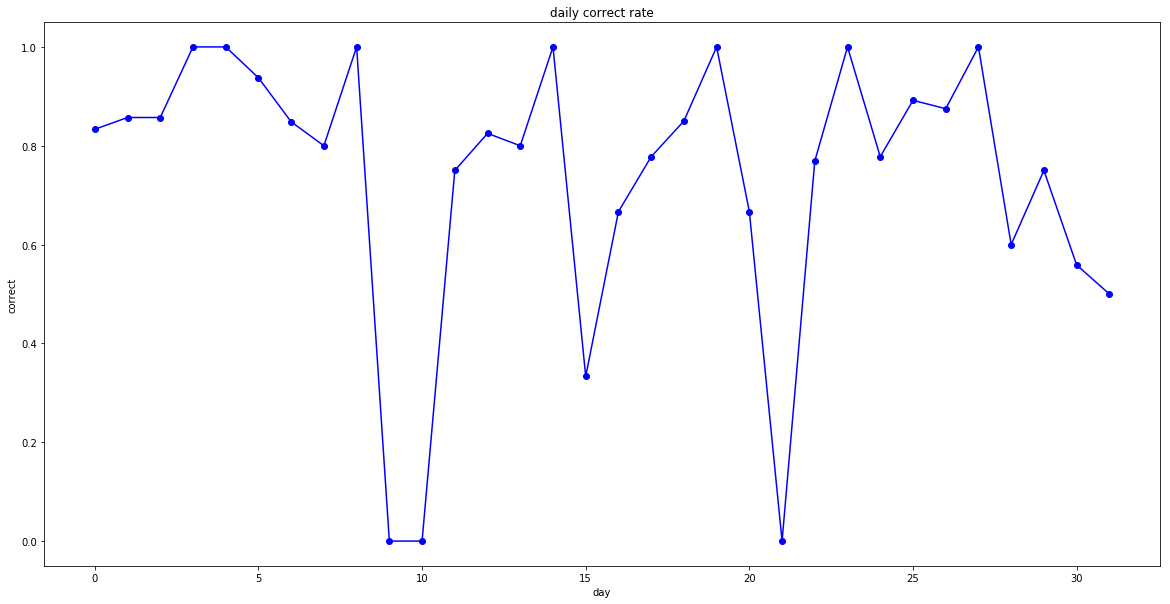

In [87]:
import matplotlib.pyplot as plot

day = daily.index.values
rate = daily.correct_rate.values
plot.figure(figsize=(20,10))
plot.ylabel('correct')
plot.xlabel("day")
plot.plot(day, rate, color='blue', marker='o', linestyle='solid')
plot.title('daily correct rate')
plot.show()

# 预测 - 竞彩

## 获取预测比赛列表

In [88]:
connection = pymysql.connect(host='localhost', user='root', password='breadt@2019', db='breadt-football-ml', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = 'select * from `breadt_lottery_predict_info` where issue = %d;' % (0)
    cursor.execute(sql)
    rows = cursor.fetchall()
    
    predict_game_df = pd.DataFrame(rows)
    
    connection.close()

In [89]:
predict_game_df = predict_game_df[(predict_game_df['game'].isin(match_group))]
predict_game_df = predict_game_df.dropna()

In [90]:
predict_game_df['year'] = predict_game_df.apply(lambda row: row.time.year, axis=1)
predict_game_df['month'] = predict_game_df.apply(lambda row: row.time.month, axis=1)
predict_game_df['day'] = predict_game_df.apply(lambda row: row.time.day, axis=1)

In [91]:
predict_game_df = encode_team(predict_game_df)
predict_game_df = encode_game(predict_game_df)

## 获取预测特征数据

In [92]:
connection = pymysql.connect(host='localhost', user='root', password='breadt@2019', db='breadt-football-ml', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = 'select * from `breadt_football_feature_info` where matchid in (select matchid from `breadt_lottery_predict_info` where issue = %d);' % (0)
    cursor.execute(sql)
    rows = cursor.fetchall()
    
    predict_feature_df = pd.DataFrame(rows)
    
    connection.close()

In [104]:
predict_feature_df[predict_feature_df['matchid']==2514645]

,h_battle_with_end_10_draw,h_battle_with_end_10_lose,h_battle_with_end_10_win,h_battle_with_front_10_draw,h_battle_with_front_10_lose,h_battle_with_front_10_win,h_host_0_1_goal,h_host_0_goal,h_host_1_goal,h_host_2_3_goal,...,v_host_2_3_goal_rate,v_host_ab_4_goal_rate,v_host_0_goal_rate,v_host_1_goal_rate,v_host_2_goal_rate,v_host_3_goal_rate,v_host_4_goal_rate,v_host_5_goal_rate,v_host_6_goal_rate,v_host_7_goal_rate
0,40% 2,20% 1,40% 2,33% 2,50% 3,17% 1,9,2,7,2,...,0.090909,0.0,0.454545,0.454545,0.0,0.090909,0.0,0.0,0.0,0.0


In [93]:
predict_feature_df = take_count(predict_feature_df)
predict_feature_df = take_rate(predict_feature_df)
predict_feature_df = take_score(predict_feature_df)

predict_feature_df['h_current_rank'] = predict_feature_df.apply(lambda row: get_current_rank(row.h_rank), axis=1)
predict_feature_df['v_current_rank'] = predict_feature_df.apply(lambda row: get_current_rank(row.v_rank), axis=1)

predict_feature_df['h_last_rank'] = predict_feature_df.apply(lambda row: get_last_rank(row.h_rank), axis=1)
predict_feature_df['v_last_rank'] = predict_feature_df.apply(lambda row: get_last_rank(row.v_rank), axis=1)

predict_feature_df['h_is_upgrade'] = predict_feature_df.apply(lambda row: is_upgrade(row.h_rank), axis=1)
predict_feature_df['v_is_upgrade'] = predict_feature_df.apply(lambda row: is_upgrade(row.v_rank), axis=1)

predict_feature_df = take_goal_info('h', predict_feature_df)
predict_feature_df = take_goal_info('v', predict_feature_df)

## 合并预测数据

In [94]:
predict_dataset_df = pd.merge(predict_game_df, predict_feature_df, on='matchid', how='left')
predict_dataset_df = predict_dataset_df.dropna()
predict_dataset_df = predict_dataset_df.drop_duplicates(subset=['matchid'])
predict_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 61
Columns: 227 entries, draw_bet_return to v_host_7_goal_rate
dtypes: datetime64[ns](1), float64(101), int64(92), object(33)
memory usage: 90.8+ KB


In [95]:
xgpredict = xgb.DMatrix(predict_dataset_df[x_columns])

official_preds = model.predict(xgpredict, ntree_limit=model.best_iteration)
official_preds

array([1., 2., 0., 0., 1., 2., 0., 2., 2., 1., 1., 1., 2., 2., 0., 0., 0.,
       2., 0., 2., 0., 1., 2., 1., 2., 2., 0., 1., 2., 2., 2., 0., 2., 2.,
       1., 2., 1., 1., 0., 0., 1., 2., 2., 2., 2., 1., 2., 0., 2., 2., 1.],
      dtype=float32)

In [96]:
output = pd.DataFrame({
    "matchid": predict_dataset_df.matchid, 
    "home_team": predict_dataset_df.home_team, 
    "visit_team": predict_dataset_df.visit_team, 
    "time": predict_dataset_df.time, 
    "game": predict_dataset_df.game, 
    "win_bet_return":predict_dataset_df.win_bet_return,
    "draw_bet_return":predict_dataset_df.draw_bet_return,
    "lose_bet_return":predict_dataset_df.lose_bet_return,
    "pred": official_preds
})

In [97]:
output[(output['game'].isin(leagues)) & (output['time'] >= datetime.datetime.now())]

,matchid,home_team,visit_team,time,game,win_bet_return,draw_bet_return,lose_bet_return,pred
54,2502968,赫尔辛堡,佐加顿斯,2019-05-07,瑞典超,3.42,3.34,2.06,2.0
55,2502972,埃夫斯堡,北雪平,2019-05-07,瑞典超,2.45,3.36,2.69,1.0
56,2503978,维京,瓦勒伦加,2019-05-07,挪超,2.65,3.35,2.48,2.0
58,2437988,AC米兰,博洛尼亚,2019-05-07,意甲,1.63,3.81,5.68,0.0
60,2405639,曼城,莱切斯特,2019-05-07,英超,1.16,8.37,16.32,2.0
61,2429045,塞图巴尔,博阿维斯,2019-05-07,葡超,2.49,2.81,3.20,1.0


In [98]:
check_df = pd.merge(output[(output['game'].isin(leagues))], train_game_list_df[['result', 'matchid']], on='matchid', how='left')
check_df['fix_result'] = check_df.apply(lambda row: int(row.result) if row.result < 3 else 2, axis=1)
check_df['is_correct'] = check_df.apply(lambda row: 1 if row.fix_result == row.pred else 0, axis=1)
check_df = check_df.dropna()

good, count, score = cal_score(check_df)
good/(good+count), score * 100

(0.47368421052631576, 181.00000000000006)

In [99]:
check_df

,matchid,home_team,visit_team,time,game,win_bet_return,draw_bet_return,lose_bet_return,pred,result,fix_result,is_correct
0,2514645,德岛漩涡,枥木SC,2019-05-05,日乙,1.70,3.24,5.18,1.0,3.0,2,0
1,2514644,甲府风林,千叶市原,2019-05-05,日乙,1.85,3.26,4.17,2.0,0.0,0,0
2,2514643,横滨FC,京都,2019-05-05,日乙,2.23,3.03,3.22,0.0,0.0,0,1
3,2514647,町田泽维,水户蜀葵,2019-05-05,日乙,2.90,2.81,2.58,0.0,0.0,0,1
4,2514650,山形山神,冈山绿雉,2019-05-05,日乙,2.23,2.91,3.39,1.0,3.0,2,0
5,2514649,江原FC,仁川联队,2019-05-05,韩K联,2.01,3.27,3.50,2.0,3.0,2,1
6,2514648,水原三星,首尔FC,2019-05-05,韩K联,2.54,3.14,2.67,0.0,1.0,1,0
8,2437990,恩波利,佛罗伦萨,2019-05-05,意甲,2.42,3.64,2.74,1.0,3.0,2,0
9,2502969,法尔肯堡,马尔默,2019-05-05,瑞典超,8.03,4.82,1.34,0.0,0.0,0,1
10,2502970,卡尔马,厄斯特松,2019-05-05,瑞典超,2.09,3.24,3.44,1.0,1.0,1,1
